In [5]:
from copy import deepcopy
from functools import partial
from typing import Callable, Dict, Generator, List, Tuple
from sklearn.model_selection import train_test_split

from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import torch
from torch import nn
from torchtext import vocab
from torchtext.vocab import GloVe
from torchtext.data.utils import get_tokenizer

from tqdm.auto import tqdm

dataset = load_dataset("imdb")


/Users/nanditraore/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Found cached dataset imdb (/Users/nanditraore/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)
100%|██████████| 3/3 [00:00<00:00, 62.01it/s]


# GloVe

In [6]:
torch.manual_seed(0)

In [7]:
glove = GloVe(name="6B", dim=300)
len(glove.stoi)

400000

In [8]:
glove.stoi["cat"], glove.itos[5450], glove.vectors[glove.stoi["cat"]].shape

(5450, 'cat', torch.Size([300]))

In [9]:
glove.itos[:5]

['the', ',', '.', 'of', 'to']

In [10]:
words = ["cat", "cats", "dog", "fridge"]
for word in words[1:]:
    similarity = torch.cosine_similarity(
        glove.vectors[glove.stoi[words[0]]].reshape(1, -1),
        glove.vectors[glove.stoi[word]].reshape(1, -1),
    ).item()  # .item() is used to turn a tensor of a single value to a float
    print(f"{words[0]} x {word} = {similarity}")


cat x cats = 0.6815836429595947
cat x dog = 0.6816746592521667
cat x fridge = 0.09630905091762543


In [11]:
word_cat = "cat"

def closest_word() :
    max_similarity = 0
    max_string_similarity = word_cat
    for word in glove.itos:
        similarity =  torch.cosine_similarity(
            glove.vectors[glove.stoi[word]].reshape(1, -1),
            glove.vectors[glove.stoi[word_cat]].reshape(1, -1),
        ).item()  # .item() is used to turn a tensor of a single value to a float
        if (similarity > max_similarity and word != word_cat):
                max_similarity = similarity
                max_string_similarity = word
                #print(f"{max_string_similarity} x {word_cat} = {max_similarity}")
    print(f"{max_string_similarity} x {word_cat} = {max_similarity}")
    

In [12]:
closest_word()

dog x cat = 0.6816746592521667


In [13]:
dataset = load_dataset("imdb")
train_dataset = dataset["train"].train_test_split(
    stratify_by_column="label", test_size=0.2, seed=42
)
test_df = dataset["test"]
train_df = train_dataset["train"]
valid_df = train_dataset["test"]
train_df.shape, valid_df.shape, test_df.shape

Found cached dataset imdb (/Users/nanditraore/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)
100%|██████████| 3/3 [00:00<00:00, 315.76it/s]
Loading cached split indices for dataset at /Users/nanditraore/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-5f37fd0866e4f89f.arrow and /Users/nanditraore/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-dd5732a0e6ac784c.arrow


((20000, 2), (5000, 2), (25000, 2))

In [14]:
tokenizer = get_tokenizer("basic_english", language="en")

def vectorize_text(
    text: str, vocabulary: vocab.Vocab, tokenizer: Callable[[str], List[str]]
) -> torch.Tensor:
    """
    Turn a string into the average of the vectors of its tokens.
    Args:
        text: the input text.
        vocabulary: a pre-trained Vocab object.
        tokenizer: a tokenizer taking a text as input and returning a list of tokens.
    Returns:
        The average tensor over the tokens of the whole text.
    """
    tokens = tokenizer(text)
    vectors = vocabulary.get_vecs_by_tokens(tokens)
    return torch.mean(vectors, dim=0)
    # Your code

In [15]:
text_pipeline = partial(vectorize_text, vocabulary=glove, tokenizer=tokenizer)
assert text_pipeline("some text.").shape == torch.Size([300])

In [16]:
text_pipeline("some text.").shape

torch.Size([300])

In [17]:
X_train = [text_pipeline(text) for text in tqdm(train_df["text"])]
y_train = train_df["label"]
X_valid = [text_pipeline(text) for text in tqdm(valid_df["text"])]
y_valid = valid_df["label"]
X_test = [text_pipeline(text) for text in tqdm(test_df["text"])]
y_test = test_df["label"]

100%|██████████| 25000/25000 [00:18<00:00, 1338.70it/s]


In [18]:
def data_generator(
    X: List[torch.tensor], y: List[int], batch_size: int = 32
) -> Generator[Tuple[torch.Tensor, torch.Tensor], None, None]:
    """
    Yield batches from given input data and labels.
    Args:
        X: a list of tensor (input features).
        y: the corresponding labels.
        batch_size: the size of every batch [32].
    Returns:
        A tuple of tensors (features, labels).
    """
    X, y = shuffle(X, y)
    num_batches = (len(X) - 1) // batch_size + 1

    for i in range(num_batches) :
        starting_index = i * batch_size
        ending_index = min((i + 1) * batch_size, len(X))
        batch_X = X[starting_index:ending_index]
        batch_Y = y[starting_index:ending_index]
        yield torch.stack(batch_X), torch.tensor(batch_Y)


In [19]:
train_gen = lambda: data_generator(X_train, y_train, batch_size=32)
for X, y in train_gen():
    #print(X.shape)
    assert X.shape == torch.Size([32, 300])
    assert y.shape == torch.Size([32])
    break

In [20]:
class SimpleClassifer(nn.Module):
    """
    A simple linear classifier.
    """

    def __init__(self, embedding_size: int, nb_classes: int) -> None:
        """
        Args:
            embedding_size: the dimension of the input embeddings.
        nb_classes: the output dimension.
        """
        super().__init__()
        output_layer = nn.Sigmoid() if nb_classes == 1 else nn.Softmax()
        self.classifier = torch.nn.Sequential(
            nn.Linear(embedding_size, nb_classes),
            output_layer,
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: an input tensor
        Returns:
            Logits.
        """
        return self.classifier(x)
        

In [21]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [22]:
train_gen = lambda: data_generator(X_train, y_train)
valid_gen = lambda: data_generator(X_valid, y_valid)
test_gen = lambda: data_generator(X_test, y_test)

In [23]:
model = SimpleClassifer(300, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
# You can use another optimizer if you want.
optimizer = torch.optim.Adam(model.parameters())

In [24]:
import math

nb_epochs = 50
train_losses, valid_losses = [], []

best_model = model
best_validation_loss = np.Inf

for epoch in tqdm(range(nb_epochs)):

    # training
    model.train()
    train_loss = 0.0
    # training loop
    for batch_X, batch_Y in train_gen():
        optimizer.zero_grad()
        logits = model(batch_X.to(device)).squeeze()
        loss = criterion(logits, batch_Y.float())#to device
        train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
      
    train_losses.append(train_loss / len(X_train))


    
    # validation
    model.eval()
    valid_loss = 0.0
    # validation loop
    with torch.no_grad():
        for batch_X, batch_Y in valid_gen():
            logits = model(batch_X.to(device)).squeeze()
            loss = criterion(logits, batch_Y.float())
            valid_loss += loss.item()
    valid_losses.append(valid_loss / len(X_valid))

    if (valid_losses[-1] < best_validation_loss) :
        best_validation_loss = valid_losses[-1]
        best_model = deepcopy(model)

print(best_validation_loss)
print(train_losses)
print(valid_losses)
    

100%|██████████| 50/50 [00:09<00:00,  5.21it/s]

0.018923558747768403
[0.021659295138716696, 0.02124224317073822, 0.02088166713118553, 0.020635808646678924, 0.020452489534020422, 0.020302874222397804, 0.02017060003876686, 0.02005131010711193, 0.01994435657262802, 0.019847798988223076, 0.019761236706376077, 0.019686215656995774, 0.019613857927918435, 0.019553485316038132, 0.019495041924715042, 0.01944295780658722, 0.01939616546332836, 0.019351739338040352, 0.019309647968411444, 0.019272623991966248, 0.0192377144664526, 0.019203860220313073, 0.019173264642059804, 0.01914372842311859, 0.019117802000045776, 0.019092281797528268, 0.019066058680415155, 0.019044395834207535, 0.01902356532514095, 0.019003152534365655, 0.01898302835226059, 0.01896500976085663, 0.01894654606282711, 0.018930311231315135, 0.018913531836867333, 0.018898937179148197, 0.01888406974673271, 0.018870708049833776, 0.018856332620978355, 0.0188427346393466, 0.018829976209998132, 0.018818544241786004, 0.018806759664416313, 0.018795015217363834, 0.018783222323656083, 0.018

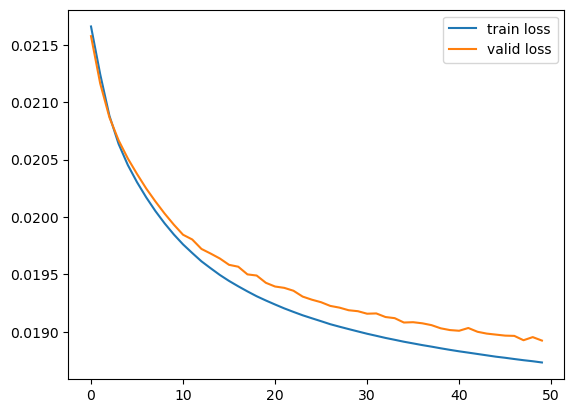

In [25]:
plt.plot(train_losses, label="train loss")
plt.plot(valid_losses, label="valid loss")
plt.legend()

In [26]:
def accuracy_computing(generator,X):
    best_model.eval()
    final_loss = 0
    accuracy = 0
    with torch.no_grad():
        for batch_X, batch_Y in generator():
            logits = best_model(batch_X).squeeze()
            loss = criterion(logits, batch_Y.float())
            final_loss += loss.item()
            predictions = (logits > 0)
            accuracy += (predictions == batch_Y).float().mean().item()
    final_loss /= len(X)
    accuracy /= len(X)
    return 1 - accuracy
        

train_accuracy = accuracy_computing(train_gen, X_train)
valid_accuracy = accuracy_computing(valid_gen, X_valid)
test_accuracy = accuracy_computing(test_gen, X_test)

print(train_accuracy, valid_accuracy, test_accuracy)

0.984375 0.98428125 0.9843525


# II- FastText

In [27]:
import fasttext as ft

1- Turn the dataset into a dataset compatible with Fastext

In [28]:
import string

def preprocess(data : dict) -> dict:
    '''Takes a document from a dataset, lowers the letters and
    replace all punctuations by spaces'''
    text = data["text"]
    for character in string.punctuation:
        if character != "-":
          text = text.replace(character, ' ')
    data["text"] = text.lower()
    return data

In [29]:
updated_dataset = dataset.map(preprocess)


Loading cached processed dataset at /Users/nanditraore/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-ab3a7119bbf33038.arrow
Loading cached processed dataset at /Users/nanditraore/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-4b4bf0f1f7f30d24.arrow
Loading cached processed dataset at /Users/nanditraore/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-ed3318b52d5380e8.arrow


In [30]:
def to_ft_dataset(dataset, file):
    with open(file, 'w') as f:
        for d in dataset:
            label = '__label__' + str(d['label'])
            text = d['text']
            f.write(label + ' ' + text + '\n')
    return file

2- Train a FastText classifier with default parameters

In [31]:
train_ft_file = to_ft_dataset(updated_dataset["train"], "ft_train_dataset.txt")
test_ft_file = to_ft_dataset(updated_dataset["test"], "ft_test_dataset.txt")

In [32]:
import random

with open("ft_train_dataset.txt", 'r') as f:
    train_lines = f.readlines()

# Shuffle the training data
shuffle(train_lines)
with open("ft_train_dataset.txt", 'w') as f:
    f.writelines(train_lines)

In [33]:
model = ft.train_supervised(input="ft_train_dataset.txt")

Read 6M words
Number of words:  96171
Number of labels: 2
Progress: 100.0% words/sec/thread: 3210760 lr:  0.000000 avg.loss:  0.349749 ETA:   0h 0m 0s


In [34]:
_, p, _ = model.test(test_ft_file)
print("L'accuracy est de:", p, "%")

L'accuracy est de: 0.85896 %


3- Use the hyperparameters search functionality of FastText

In [35]:

with open("ft_train_dataset.txt", 'r') as f:
    data = []
    labels = []
    for line in f:
        label, text = line.split(maxsplit=1)
        data.append(text)
        labels.append(label)

X_train, X_valid, Y_train, Y_valid = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)

# Combine the data and labels into the format expected by FastText
train = [f"{label} {text.strip()}\n" for label, text in zip(Y_train, X_train)]
val = [f"{label} {text.strip()}\n" for label, text in zip(Y_valid, X_valid)]

# Save the training and validation data to separate files
with open('ft_train_dataset.txt', 'w') as f:
    f.writelines(train)
with open('ft_valid_dataset.txt', 'w') as f:
    f.writelines(val)


In [40]:
model_hyperparameters = ft.train_supervised(input='ft_train_dataset.txt', autotuneValidationFile='ft_valid_dataset.txt', autotuneDuration=300)

Progress: 100.0% Trials:   18 Best score:  0.896200 ETA:   0h 0m 0s
Training again with best arguments
Read 4M words
Number of words:  86168
Number of labels: 2
Progress: 100.0% words/sec/thread: 2416360 lr:  0.000000 avg.loss:  0.165621 ETA:   0h 0m 0s


In [41]:
_, p, _ = model.test("ft_valid_dataset.txt")
print("L'accuracy est de:", p, "%")

L'accuracy est de: 0.8746 %
